# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: Ultimately, this problem is a classification one. The end result is that we have broken up the pool of students into those who a) will not need any help to graduate and b) those who will need help so that they graduate. That being said, if one was operating over the space [0, 1] and had a model which returned any real number between 0 and 1, that model would be a regressive one. Then if you broke your space into two parts, say: [0, 1/4] U (1/4, 1] the students who fall into the first subsection could then be labeled as needing more help, while those who fell into the second subsection would not need help. Therefore, this problem ultimately boils down to a classificiation problem**

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [14]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score

# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

Student data read successfully!


### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [15]:
#print student_data.info()

# TODO: Calculate number of students
n_students = student_data.shape[0]

# TODO: Calculate number of features
n_features = len(student_data.columns[:-1])

df1 = student_data[['passed']]
ans = df1['passed'].values.tolist()

# TODO: Calculate passing students
n_passed = 0

# TODO: Calculate failing students
n_failed = 0

for each_std in ans:
    if each_std == 'yes':
        n_passed += 1
    else:
        n_failed += 1

# TODO: Calculate graduation rate
grad_rate = (float(n_passed) / float(n_failed + n_passed))*100

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


## Preparing the Data
In this section, we will prepare the data for modeling, training, and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [16]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

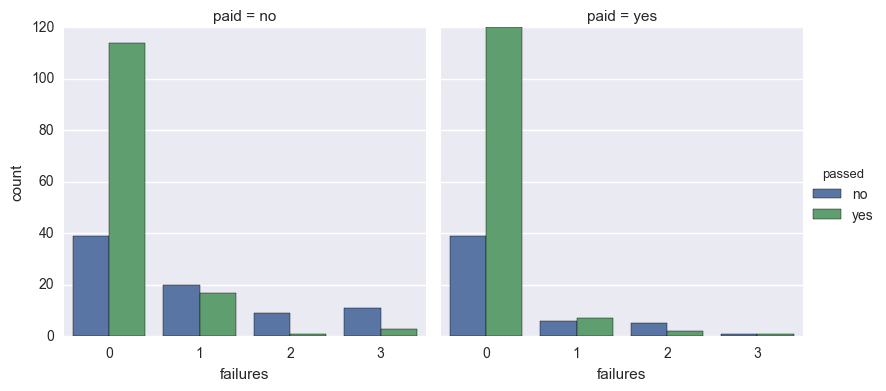

In [17]:
%matplotlib inline
import seaborn as sns
sns.factorplot("failures", col="paid", data=student_data, hue='passed', kind="count");

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [18]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [19]:
# TODO: Import any additional functionality you may need here
from sklearn.cross_validation import train_test_split

# TODO: Set the number of training points
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# TODO: Shuffle and split the dataset into the number of training and testing points above

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, train_size=num_train, random_state=35)


# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 300 samples.
Testing set has 95 samples.


According to here: https://discussions.udacity.com/t/trouble-using-shufflesplit/178149/3 we do not need to use the ShuffleSplit method (which is what I was originally doing). Just using Train_test_split, I think we could argue that the data is not first being shuffled around, however, it is being split randomly -- which about amounts to choosing a random shuffled subset.

## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. *(You may need to do a small bit of research for this — give references!)* 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: **

**AdaBoost/Ensemble Methods:**

**a. "We also concluded that this algorithm gives much better results when applied on simpler objects (like face recognition) and that its application could be in detection of players’ body parts or as a first step in object detection in order to eliminate as much area as possible." (https://uni-obuda.hu/journal/Markoski_Ivankovic_Ratgeber_Pecev_Glusac_57.pdf) In this instance, Ababoost is being used for a detecting people given an input space of video footage. Adaboost is used because watching the videos, the learner can come up with several simple types of rules -- ie "is the jersey color a or b?" or "What number does each player have on their jersey?" (granted that last one would be terribly overfit, however, it is one such example of a weak learner and therefore applicible to ensemble learners.**

**b. One of the strength of AdaBoost/ensemble methods is that even as they get more and more data, their testing error continues to go down -- they do not follow the normal trend of overfitting. While ensemble methods do still suffer from the Curse of Dimentionsality, the AdaBoost "training process selects only those features known to improve the predictive power of the model, reducing dimensionality and potentially improving execution time as irrelevant features do not need to be computed" (https://en.wikipedia.org/wiki/AdaBoost).**

**c. One of the large weaknesses of ensemble methods is that they rely on having a good choice of a weak learner. If the weak learner that you're using is itself prone to overfitting the data, then the ensemble learner you're using will itself get stuck in a loop of selecting that overfit weak-learner and then not learn itself. Furthermore, this method can be thrown off by uniforn noise.**

**d. AdaBoost is a good choice of model (probably with a Decision Tree base) for this problem given the large number of features in the dataset since as noted above in b. "the AdaBoost "training process selects only those features known to improve the predictive power of the model.**

**Support Vector Machines:**

**a. Applications of Support Vector Machines are text and hypertext classification, image classification, recognizing handwritten characters, and protien and cancer classifications (www-labs.iro.umontreal.ca/~pift6080/H09/documents/papers/svm_tutorial.ppt).**

**b. The strengths of SVMs are: it is a flexible algorithm when choosing a similarity function, only support vectors are used when specifying the hyperplanes, they can handle large data sets with many features, overfitting can be countered with a soft-margin, and due to the mathematical nature of the algorithm, we can guarantee a single global solution (see above link).**

**c. The weakness' of SVMs are in that the algorithm is quite sensitive to noise as a small amount of mislabled examples can decrease the performace of the algorithm, furthermore, it can only consider two classes at at time (see above link).**

**d. Given the many features present in this data set (31 features originally which then got upgraded to 48 total features per student), SVMs seem like they'll be a good thing to try as the algorithm can easily handle a large number of features and create a flexible classifier by which to sort the students**

**K-Nearest-Neighbors:**

**a. Applications of KNN include: predicting economic events (http://www.ijera.com/papers/Vol3_issue5/DI35605610.pdf), recommender and hybrid-recommender (https://en.wikipedia.org/wiki/Recommender_system), and evaluating similarity in objects since objects are compared against nearby (and thusly assumed similar) objects.**

**b. KNN is among the simplist of machine learning algoriths (https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm#Properties). Because no "training" takes place and the algorithm simply uses the dataset itself, it is incredibly easy for more data to be added to the problem. Furthermore, given that K is a hyperparameter, we can tune it down to granular specificity of exactly how many neighbors you want to compare against.**

**c. One of the pitfalls of the algorithm is that you need to bring in your own metric (a way to measure similarity) since the "nomral" ones such as L2 might not work so well in your exact setting. Also, as your increase k towards N, the algorithm's output is going to head towards the mean of the dataset since each point will be compared to every other point and therefore have a minimal effect on the output.**

**d. Given how much knn can be controlled and that students who might be failing are likely to group together -- or at least show similar warning signs of failing -- KNN makes sense as an algorithm to use when building a student detection system.**

### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [20]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [21]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample

# TODO: Initialize the three models
clf_A = AdaBoostClassifier(random_state=21) #using default decision trees as base
clf_B = SVC(random_state=75)
clf_C = KNeighborsClassifier() #default 5-NN

# TODO: Set up the training set sizes
X_train_100 = resample(X_train, n_samples=100, random_state=24)
y_train_100 = resample(y_train, n_samples=100, random_state=24)

X_train_200 = resample(X_train, n_samples=200, random_state=24)
y_train_200 = resample(y_train, n_samples=200, random_state=24)

X_train_300 = resample(X_train, n_samples=300, random_state=24)
y_train_300 = resample(y_train, n_samples=300, random_state=24)

# TODO: Execute the 'train_predict' function for each classifier and each training set size
# train_predict(clf, X_train, y_train, X_test, y_test)
train_predict(clf_A, X_train_100, y_train_100, X_test, y_test)
train_predict(clf_A, X_train_200, y_train_200, X_test, y_test)
train_predict(clf_A, X_train_300, y_train_300, X_test, y_test)
print
train_predict(clf_B, X_train_100, y_train_100, X_test, y_test)
train_predict(clf_B, X_train_200, y_train_200, X_test, y_test)
train_predict(clf_B, X_train_300, y_train_300, X_test, y_test)
print
train_predict(clf_C, X_train_100, y_train_100, X_test, y_test)
train_predict(clf_C, X_train_200, y_train_200, X_test, y_test)
train_predict(clf_C, X_train_300, y_train_300, X_test, y_test)

Training a AdaBoostClassifier using a training set size of 100. . .
Trained model in 0.1419 seconds
Made predictions in 0.0064 seconds.
F1 score for training set: 0.9861.
Made predictions in 0.0063 seconds.
F1 score for test set: 0.7040.
Training a AdaBoostClassifier using a training set size of 200. . .
Trained model in 0.1512 seconds
Made predictions in 0.0064 seconds.
F1 score for training set: 0.9104.
Made predictions in 0.0097 seconds.
F1 score for test set: 0.7424.
Training a AdaBoostClassifier using a training set size of 300. . .
Trained model in 0.1732 seconds
Made predictions in 0.0102 seconds.
F1 score for training set: 0.9255.
Made predictions in 0.0146 seconds.
F1 score for test set: 0.7176.

Training a SVC using a training set size of 100. . .
Trained model in 0.0036 seconds
Made predictions in 0.0015 seconds.
F1 score for training set: 0.8987.
Made predictions in 0.0011 seconds.
F1 score for test set: 0.7600.
Training a SVC using a training set size of 200. . .
Trained m

### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

** Classifer 1 - AdaBoost (built on Decision Trees)**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |         0.1843          |         0.0061         |      1.0000      |        0.6829   |
| 200               |        0.1545           |      0.0060            |      1.0000      |     0.6357      |
| 300               |        0.1436           |     0.0067             |      0.9977      |    0.6929       |

** Classifer 2 - Support Vector Machines (Classification)**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |         0.0012          |      0.0007            |    0.8304        |     0.7662      |
| 200               |     0.0025              |      0.0016            |     0.8166       |     0.7622      |
| 300               |     0.0055              |      0.0041            |     0.8372       |     0.7662      |

** Classifer 3 - K-Nearest-Neighbor (Classifier)**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |          0.0008         |       0.0014           |       0.9007     |      0.7121     |
| 200               |          0.0008         |       0.0031           |       0.8826     |      0.7385     |
| 300               |          0.0008         |       0.0064           |       0.9108     |      0.7424     |

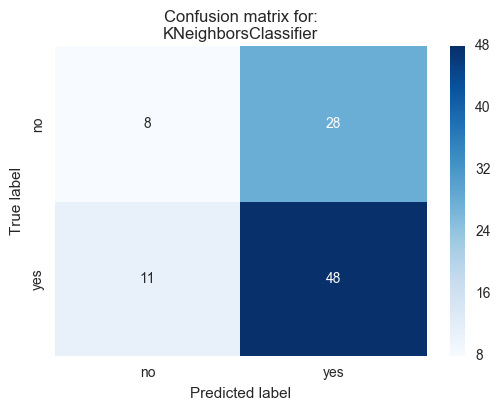

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Compute confusion matrix for a model
model = clf_C
cm = confusion_matrix(y_test.values, model.predict(X_test))

# view with a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__));

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: The model which I believe to be the best is the K-(nearest)-neighbors classifier. The ways in which I scored the three models I created against each other were: how long it took to create the model, how long it took the model to return with an answer, how well the model did on the training data, and finally how well the model was able to take what it learned on the training data and perform on the hidden testing data. Each model performed to about the same level of accuracy on the training data -- between 0.817 and 1.000, therefore that piece of result data did not factor into my decision of which model to pick. The remaining three however, did. Were I judging just by how well each model performed on the testing-set, I would have picked the Support Vector Classifier. Furthermore, Support Vector Machines also performed very well in their prediction timing. However, the amount of correctly classified students remained constant as data increased. The classifier which learned the most as the data increased was KNN. Although KNN has the highest precition cost, that cost is offset by the increadily short training time, as shown by the fact that if you sum up the running times (training + predicting) for each model at each subset, KNN is the one which minimizes that sum. Furthermore, KNN showed the most growth in its F1 score as the amount of data increased. AdaBoosted Decision trees were thrown right out because they took the longest to train and had the worst accuracy among all three methods tested.**

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: K-Nearest-Neighbor is a model which, at its core, seeks to compare each student(read: data point) with all the other students in the set. The driving idea behind the algorithm is that data points that are similar will reside close to each other in the data(read: domain). Once you've imported all the data, the model is trained. The way that first you need to come up with a way to measure how similar each student is (usually a distance metric). Then you select how many students you would like to compare every other student against -- k. For each student (read: data point) you then find out if the k other students are passing or failing. Once you know the properties of each of those students, you then have all the nearby students vote. If the (weighted or unweighted) majority of the nearby students are going to graduate, then you say that the original student you were looking at is going to graduate.**

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [23]:
print "F1 score for predicting all \"yes\" on test set: {:.4f}".format(
    f1_score(y_test, ['yes']*len(y_test), pos_label='yes', average='binary'))

F1 score for predicting all "yes" on test set: 0.7662


In [26]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn import cross_validation
# TODO: Create the parameters list you wish to tune

max_neighbors = 31

parameters = {'n_neighbors':range(1, max_neighbors)}

# TODO: Initialize the classifier
clf = KNeighborsClassifier()
print clf.get_params().keys()

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label='yes')

cv_sets = cross_validation.StratifiedShuffleSplit(y_train, n_iter = 50, random_state = 42)

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf, param_grid=parameters, cv=cv_sets, scoring=f1_scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_
print clf

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

['n_neighbors', 'n_jobs', 'algorithm', 'metric', 'metric_params', 'p', 'weights', 'leaf_size']
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=22, p=2,
           weights='uniform')
Made predictions in 0.0070 seconds.
Tuned model has a training F1 score of 0.8476.
Made predictions in 0.0025 seconds.
Tuned model has a testing F1 score of 0.7651.


Funnily enough, I found that making the parameter grid more complex led to worse F1 scores in the testing set. You would think that if all that you provided was the k-value to itereate over, then the other hyper-parameters would take up their "auto" values. Now, if you had more of those hyper-parameters specified, one would think that you would be able to find the same tuned model as before when you were only specifying k, whenever the rest of the parameters happened to match up with what their values would have been when automatically chosen. However, that was not the case. The resultant classifier that got chosen in the case where the paramter grid was larger was less correct in its testing score. As such, I swithed back to just iterating through a number of k-values.

### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: The final model's F1 score for training is: 0.8476. The final model's F1 score for testing is: 0.7651. For the untuned model, at a training size of 300, the training score was 0.8202 and the testing score was 0.7626. Therefore, the optimized/tuned model  performed better on BOTH the training and the testing data!**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.